**Domain Background**：


        这是一个来自于Kaggle的真实竞赛项目，项目要求预测Rossmann的日常销售。Rossmann是一个在7个欧洲国家经营着3,000多家药店。目前，Rossmann商店经理的任务是预先提前六周预测他们的日常销售。商店销售受许多因素的影响，包括促销，竞争，学校和州假日，季节性和地方性。成千上万的个体经理根据他们独特的情况预测销售情况，结果的准确性可能会有很大差异。
    在Kaggle的比赛中，Rossmann向您提出挑战，要求您预测德国各地的1,115家商店每周销售6周。可靠的销售预测可以使商店经理能够创建有效的员工时间表，从而提高生产力和动力。通过帮助Rossmann创建一个强大的预测模型，您将帮助商店经理专注于对他们最重要的事情：他们的客户和他们的团队！ 
之所以选择这个项目，是因为该项目与我的实际工作中亟待解决的问题同出一辙。


**Problem Statement**：


        该项目的具体任务是在1,115家Rossmann商店的历史销售数据中预测测试集的“Sales”列，这属于线性回归类的需求。可以通过构建一个有监督学习类的模型来减少预测值（ŷ）与实际值（y）之间的误差来解决本需求。
    使用Kaggle的RMSPE 函数来验证真实的销售数据与预测数据的差异性。RMSPE 函数：

<img src="rmspe.png" width="20%"></img>

In [1]:
#导入所需要的库
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import xgboost as xgb
from time import time

In [3]:
#读取数据
train = pd.read_csv('train.csv',parse_dates=[2])
test = pd.read_csv('test.csv',parse_dates=[3])
store = pd.read_csv('store.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
#查看训练集
train.head().append(train.tail())

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
742,743,5,2015-07-31,5085,501,1,1,0,1
748,749,5,2015-07-31,6612,716,1,1,0,1
747,748,5,2015-07-31,7481,578,1,1,0,1
746,747,5,2015-07-31,10708,826,1,1,0,1
1016471,377,2,2013-01-01,0,0,0,0,a,1
1016472,378,2,2013-01-01,0,0,0,0,a,1
1016473,379,2,2013-01-01,0,0,0,0,a,1
1016474,380,2,2013-01-01,0,0,0,0,a,1
1017208,1115,2,2013-01-01,0,0,0,0,a,1


In [11]:
#查看测试集
test.head().append(test.tail())


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0
41083,41084,1111,6,2015-08-01,1.0,0,0,0
41084,41085,1112,6,2015-08-01,1.0,0,0,0
41085,41086,1113,6,2015-08-01,1.0,0,0,0
41086,41087,1114,6,2015-08-01,1.0,0,0,0
41087,41088,1115,6,2015-08-01,1.0,0,0,1


In [12]:
#查看店铺信息
store.head().append(store.tail())

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN
1114,1115,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


In [13]:
#查看数据缺失
display(train.isnull().sum(),test.isnull().sum(),store.isnull().sum())

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [14]:
#缺失数据分析
#测试集缺失数据
test[pd.isnull(test.Open)]


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
479,480,622,4,2015-09-17,NaN,1,0,0
1335,1336,622,3,2015-09-16,NaN,1,0,0
2191,2192,622,2,2015-09-15,NaN,1,0,0
3047,3048,622,1,2015-09-14,NaN,1,0,0
4759,4760,622,6,2015-09-12,NaN,0,0,0
5615,5616,622,5,2015-09-11,NaN,0,0,0
6471,6472,622,4,2015-09-10,NaN,0,0,0
7327,7328,622,3,2015-09-09,NaN,0,0,0
8183,8184,622,2,2015-09-08,NaN,0,0,0
9039,9040,622,1,2015-09-07,NaN,0,0,0


# - 缺失数据都来自于622店铺，从周1到周6而且没有假期，所以我们认为这个店铺的状态应该是正常营业的

In [15]:
#店铺集缺失数据
store[pd.isnull(store.CompetitionDistance)]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [16]:
store[pd.isnull(store.CompetitionOpenSinceMonth)].head(10)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
25,26,d,a,2300.0,NaN,NaN,0,NaN,NaN,NaN
28,29,d,c,2170.0,NaN,NaN,0,NaN,NaN,NaN
31,32,a,a,2910.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
39,40,a,a,180.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
40,41,d,c,1180.0,NaN,NaN,1,31.0,2013.0,"Jan,Apr,Jul,Oct"


In [17]:
#查看是否Promo2系列的缺失是否是因为没有参加促销
NoPW = store[pd.isnull(store.Promo2SinceWeek)]
NoPW[NoPW.Promo2 != 0].shape

(0, 10)

# - 店铺竞争数据缺失的原因不明，且数量比较多，我们可以用中值或者0来填充，后续的实验发现以0填充的效果更好
# - 店铺促销信息的缺失是因为没有参加促销活动，所以我们以0填充


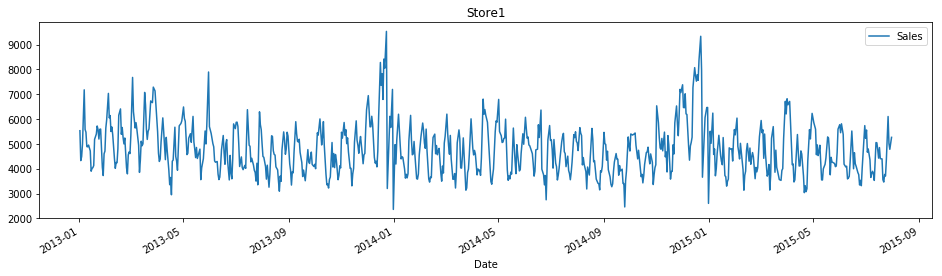

In [18]:

#分析店铺销量随时间的变化
strain = train[train.Sales>0]
strain.loc[strain['Store']==1 ,['Date','Sales']]     .plot(x='Date',y='Sales',title='Store1',figsize=(16,4))


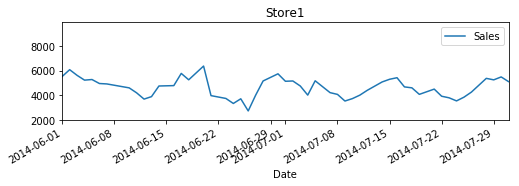

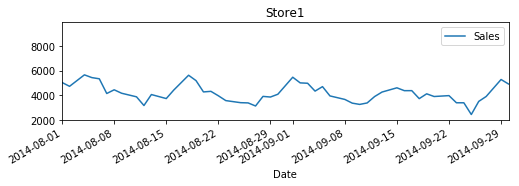

In [19]:
#分析店铺6-9月份的销量变化
strain = train[train.Sales>0]
strain.loc[strain['Store']==1 ,['Date','Sales']]     .plot(x='Date',y='Sales',title='Store1',figsize=(8,2),xlim=['2014-6-1','2014-7-31'])
strain.loc[strain['Store']==1 ,['Date','Sales']]     .plot(x='Date',y='Sales',title='Store1',figsize=(8,2),xlim=['2014-8-1','2014-9-30'])


# - 从上图的分析中，我们可以看到店铺的销售额是有周期性变化的，一年之中11，12月份销量要高于其他月份，可能有季节因素或者促销等原因.
# - 此外从对2014年6月-9月份的销量来看，6，7月份的销售趋势与8，9月份类似，因为我们需要预测的6周在2015年8，9月份，因此我们可以把2015年6，7月份最近的6周数据作为hold-out数据集，用于模型的优化和验证。
 
# 2.数据预处理


In [25]:
#缺失值处理
#我们将test中的open数据补为1，即营业状态
test.fillna(1, inplace=True)
#store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)
#store['CompetitionOpenScinceYear'].fillna(store['CompetitionDistance'].median(), inplace = True)
#store['CompetitionOPenScinceMonth'].fillna(store['CompetitionDistance'].median(), inplace = True)
 
#store中的缺失数据大多与竞争对手和促销有关，在实验中我们发现竞争对手信息的中值填充效果并不好，所以这里统一采用0填充


In [26]:
#查看是否还存在缺失值
display(train.isnull().sum(),test.isnull().sum(),store.isnull().sum())

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

Id               0
Store            0
DayOfWeek        0
Date             0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [27]:
#合并store信息
train = pd.merge(train, store, on='Store')
test = pd.merge(test, store, on='Store')

In [28]:
#留出最近的6周数据作为hold_out数据集进行测试
train = train.sort_values(['Date'],ascending = False)
ho_test = train[:6*7*1115]
ho_train = train[6*7*1115:]

In [29]:
#因为销售额为0的记录不计入评分，所以只采用店铺为开，且销售额大于0的数据进行训练
ho_test = ho_test[ho_test["Open"] != 0]
ho_test = ho_test[ho_test["Sales"] > 0]
ho_train = ho_train[ho_train["Open"] != 0]
ho_train = ho_train[ho_train["Sales"] > 0]


In [30]:

# 3.特征工程

In [31]:
#特征处理与转化，定义特征处理函数
def features_create(data):
    
    #将存在其他字符表示分类的特征转化为数字
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)
    
    #将时间特征进行拆分和转化，并加入'WeekOfYear'特征
    data['Year'] = data.Date.dt.year
    data['Month'] = data.Date.dt.month
    data['Day'] = data.Date.dt.day
    data['DayOfWeek'] = data.Date.dt.dayofweek
    data['WeekOfYear'] = data.Date.dt.weekofyear
    
    
    #新增'CompetitionOpen'和'PromoOpen'特征,计算某天某店铺的竞争对手已营业时间和店铺已促销时间，用月为单位表示
    data['CompetitionOpen'] = 12 * (data.Year - data.CompetitionOpenSinceYear) +         (data.Month - data.CompetitionOpenSinceMonth)
    data['PromoOpen'] = 12 * (data.Year - data.Promo2SinceYear) +         (data.WeekOfYear - data.Promo2SinceWeek) / 4.0
    data['CompetitionOpen'] = data.CompetitionOpen.apply(lambda x: x if x > 0 else 0)        
    data['PromoOpen'] = data.PromoOpen.apply(lambda x: x if x > 0 else 0)
    
    
    #将'PromoInterval'特征转化为'IsPromoMonth'特征,表示某天某店铺是否处于促销月，1表示是，0表示否
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',              7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    data['monthStr'] = data.Month.map(month2str)
    data.loc[data.PromoInterval == 0, 'PromoInterval'] = ''
    data['IsPromoMonth'] = 0
    for interval in data.PromoInterval.unique():
        if interval != '':
            for month in interval.split(','):
                data.loc[(data.monthStr == month) & (data.PromoInterval == interval), 'IsPromoMonth'] = 1
 
    return data

In [32]:
#对训练，保留以及测试数据集进行特征转化
features_create(ho_train)
features_create(ho_test)
features_create(test)
print('Features creation finished')

AttributeError: 'float' object has no attribute 'split'